## 환경 설정

In [2]:
import warnings
warnings.filterwarnings(action='ignore')
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import webbrowser
from IPython.display import Image

import sys
import plotly
import plotly.graph_objects as go
import plotly.express as px
import missingno

import spark
import pydot 
from IPython.display import Image
import pyarrow as pa

import json
import urllib
import math
from tqdm import tqdm
import time
from datetime import datetime
import itertools

## 전처리 ## 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

## 시계열 실습 ##
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   ### acf pacf 그래프 생성 도구
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


import tensorflow_probability as tfp
from tensorflow_probability import sts

## 자체적으로 만든 모듈
from bike_data_analysis_class import *

################### 설정 ########################
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('seaborn-whitegrid')
%matplotlib inline

# 개요

## 연구 배경

- Public Bicycle Sharing (이하 PBS) 서비스는 지속가능한 교통수단으로서 높은 이용률을 보이고 있음

- 그러나 station마다 자전거 수의 불균형이 발생하여 사용자로 하여금 빈 거치대, 혹은 꽉 차서 반납이 불가능한 상황이 지속적으로 발생

- 이를 방지하기 위해 지속적으로 거치대 상황을 모니터링하여 재배치가 이루어짐.

- 재배치 문제를 풀기 전 자전거의 예상 수요 예측을 파악할 수 있다면, 운영 계획 수립에 효과적일 것으로 예상


## Gartner Analytic Ascendancy Model

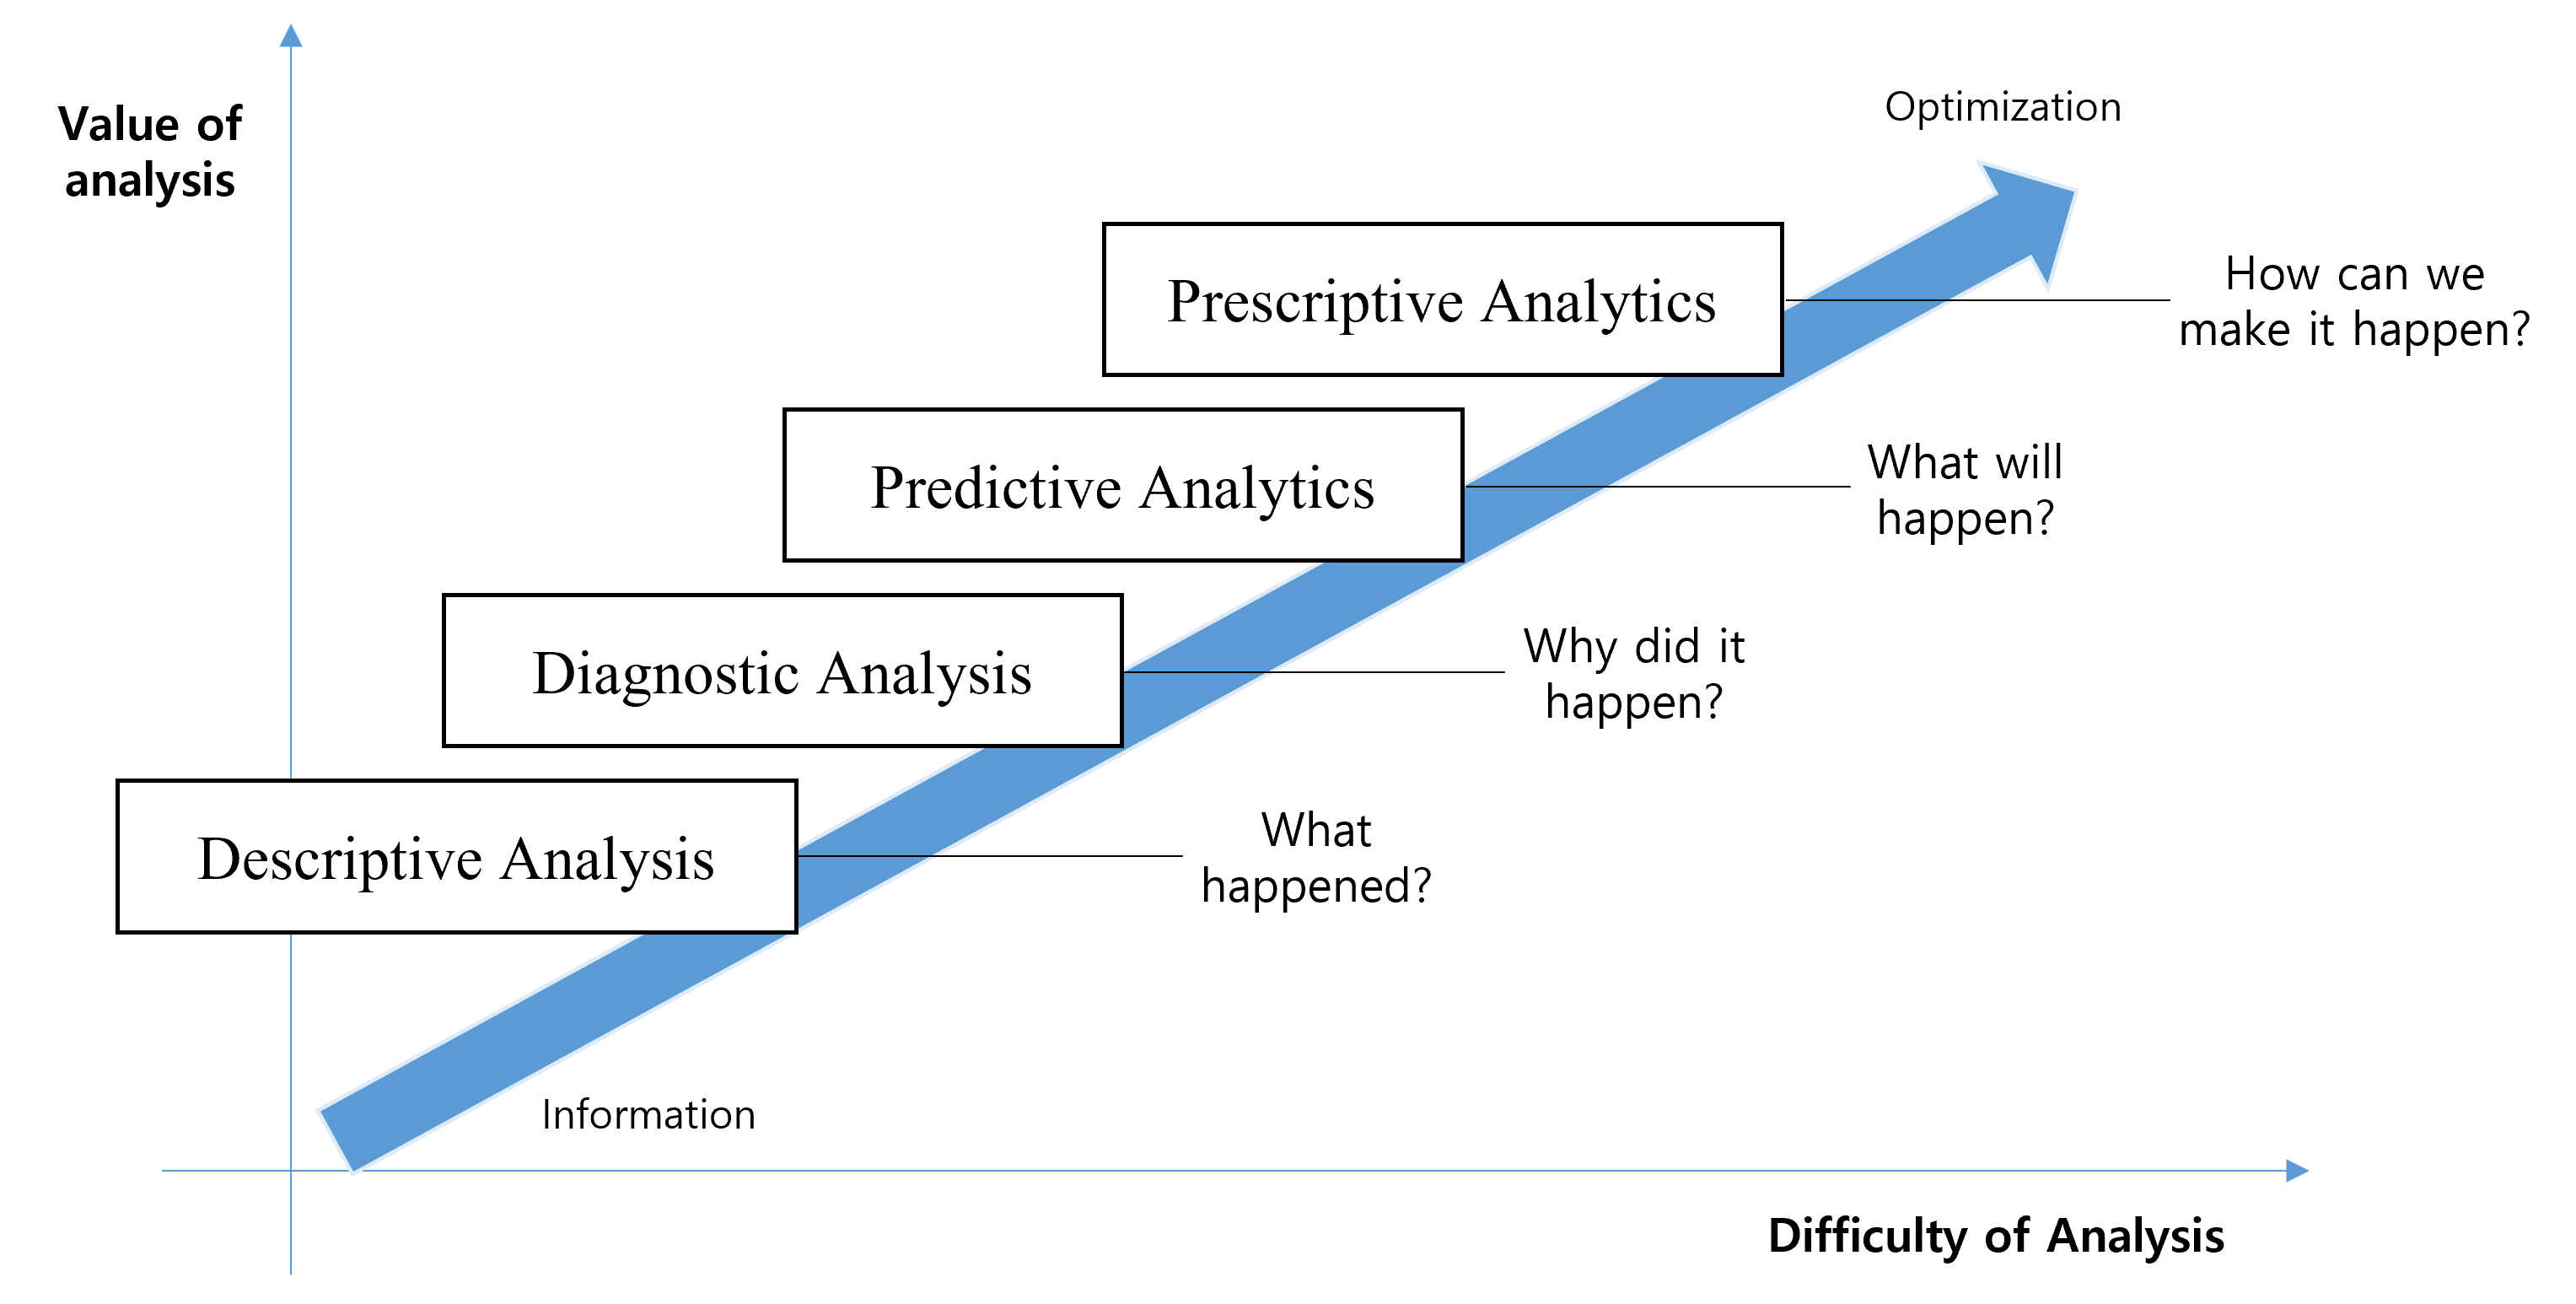

In [3]:
Image("C:/Users/Hoonyong/내 드라이브/jeong-term/공공자전거데이터/Gartner.png")

## 연구 목적

- 최종 연구 목적:
    - 강화학습과 동적 계획법을 사용한 실시간 자전거 재배치 전략 도출
 
- Term project 에서의 목적:
    - 실시간 실시간 재배치 전략을 (Prescriptive Analysis) 도출하려면 자전거의 예상 발생 수요량 예측이 우선적으로 수반되어야 함.(Predictive Analysis)
    
    - 서울시 공공자전거 대여 서비스(따릉이)의 실제 사용 raw data를 기반으로, 대여소 별 자전거의 예상 수요량을 1시간 단위로 예측하는 최적의 model 개발 


# 데이터 소개

> 서울시 공공자전거 대여이력 정보
- 2021년 연간 대여소별, 자전거별 대여이력 원천 데이터 3,000만건
- 자전거 번호를 기준으로, 대여소와 반납소 등 정보 제시

> 서울시 공공자전거 대여소 정보
- 2021년 12월 기준 서울시 대여소 데이터 약 2,000건
- 주소, 대여소번호, 위경도 좌표 등 

In [3]:
file_name = 'bike_rental_2021.parquet'
bike_df = pd.read_parquet(file_name)
bike_df.head(5)

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리
0,SPB-53145,2021-01-02 20:50:36,3,중랑센터,0,2021-01-02 21:15:41,668,서울축산농협(장안지점),0,25.00,0.00
1,SPB-53074,2021-01-04 16:02:12,3,중랑센터,0,2021-01-04 16:17:06,668,서울축산농협(장안지점),0,14.00,0.00
2,SPB-50952,2021-01-13 21:02:05,3,중랑센터,0,2021-01-13 21:14:04,668,서울축산농협(장안지점),0,11.00,1853.99
3,SPB-52380,2021-01-14 21:02:55,3,중랑센터,0,2021-01-14 21:13:41,668,서울축산농협(장안지점),0,10.00,0.00
4,SPB-52380,2021-01-18 18:02:08,3,중랑센터,0,2021-01-18 18:15:22,540,군자역 7번출구 베스트샵 앞,0,13.00,2291.05


# 데이터 전처리

In [ ]:
## 월별 따릉이 데이터를 병합 (01월~12월)

def merge_data():
    df = pd.DataFrame()
    month_list = [str(i).zfill(2) for i in range(1,13)]
    for i in month_list:
        data = pd.read_csv("공공자전거 대여이력 정보_21"+ i +".csv",encoding='cp949')
        df = pd.concat((df,data),sort=False)
        print(data.head())
    return df

bike_df = merge_data()

# 데이터 EDA

# 시계열 분석 및 모델 피팅